## Go to directory

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ML_NTHU_HW3

/content/drive/MyDrive/Colab Notebooks/ML_NTHU_HW3


In [ ]:
!ls ./CATEGORIZED_IML_CXR_TRAIN/1 | wc -l
!ls ./CATEGORIZED_IML_CXR_TRAIN/0 | wc -l

164
1229


## Setup lib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Load Data

In [ ]:
!ls CATEGORIZED_IML_CXR_TRAIN/

0  1


In [ ]:
batch_size = 128
IMG_SIZE = (320,320)
seed_num = 77777
# 53
# 47 very good performance

data_dir = 'CATEGORIZED_IML_CXR_TRAIN'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  # subset="training",
  seed=seed_num,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

# validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0,
#   subset="validation",
#   seed=seed_num,
#   image_size=IMG_SIZE, 
#   batch_size=batch_size)

class_names = train_dataset.class_names
print(class_names)

Found 1393 files belonging to 2 classes.
['0', '1']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Build Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

fine_tune_at = -20

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
inputs = keras.Input(shape=IMG_SHAPE)
x = keras.applications.densenet.preprocess_input(inputs)
x = keras.layers.experimental.preprocessing.RandomRotation((-0.01, 0.01))(x)
x = base_model(x, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x) 
model = keras.Model(inputs, outputs)

base_learning_rate = 0.000001 
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[f1_m])

# model.summary()
len(model.trainable_variables)

initial_epochs = 150
class_weight = {0: 0.1, 1: 0.9}
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    # validation_data=validation_dataset, 
                    class_weight=class_weight)


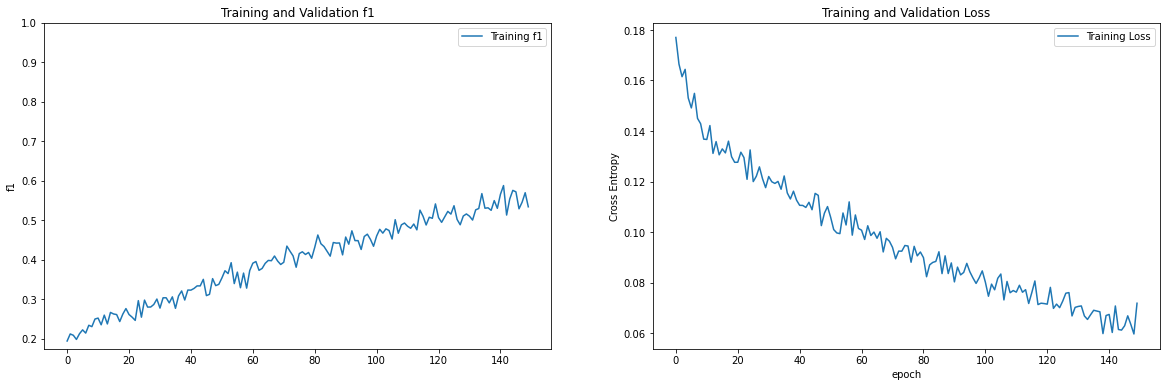

INFO:tensorflow:Assets written to: Code/img_model/assets


In [ ]:
acc = history.history['f1_m']
# val_acc = history.history['val_f1_m']

loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training f1')
# plt.plot(val_acc, label='Validation f1')
plt.legend(loc='upper right')
plt.ylabel('f1')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation f1')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('loss.png')
plt.show()

In [ ]:
# prediction = model.predict(validation_dataset, verbose=1)
# prediction = (prediction >= .5).astype(int)
# print(prediction.shape)
model.save('Code/img_model')

INFO:tensorflow:Assets written to: Code/img_model/assets


## Save Testing output for Model Image

In [ ]:
from tensorflow import keras
from keras.preprocessing import image

folder = 'IML_CXR_TEST/'
folder2 = 'IML_CXR_TRAIN/'
train_data = {'hospital_outcome':[], 'PATIENT ID':[]} 
data = []
prediction1 = []
for file in os.listdir(folder2):
  # print(file)
  test_image = image.load_img(folder2 + file, (320,320))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  data.append(test_image)
  train_data['PATIENT ID'].append(int(file[:-4]))
  # prediction1.append((model.predict(test_image) >= .5).astype(int))
tfs = tf.concat(data, 0)
prediction = model.predict(tfs)
prediction = (prediction >= .5).astype(int)
train_data['hospital_outcome'] = prediction

In [ ]:
a = np.array(prediction1).flatten().tolist()
b = prediction.flatten().tolist()
if a == b:
  print('True')
import pandas as pd
train_data['hospital_outcome'] = b
pred_img = pd.DataFrame.from_dict(train_data)[['PATIENT ID', 'hospital_outcome']] # pred_img = pd.DataFrame({'PATIENT ID': train_data['PATIENT ID'], 'hospital_outcome': b})
# pred_img.sort_values(by=['PATIENT ID'], ascending=True).to_csv('Results/107062274.csv', index = False)
pred_img.sort_values(by=['PATIENT ID'], ascending=True).to_csv('Additional Data/Train_IMG_PREDICT.csv', index = False)